<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/9_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя модель обучения многослойного персептрона из практической части урока (9.3), выполните следующее:

1. Увеличьте число слоев до 4-х и сравните время обучения модели и точность на тестовой выборке.
2. В качестве датасета использовать любой из наборов данных TensorFlow. Обучить модель. Добейтесь результата распознования более 85% на тестовой выборке. [Датасеты на выбор](https://www.tensorflow.org/datasets/overview). Используйте датасет отличный от MNIST, который был в уроке.

Для прохождения урока достаточно решить первое задание.

In [ ]:
# v1.2.0
# Устанавливаем Seaborn для построения графиков 
!pip install -q seaborn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import tempfile
import time

import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

# Установим по умолчанию размер фигуры для Matplotlib по умолчанию.
matplotlib.rcParams["figure.figsize"] = [9, 6]

In [2]:
train_data, val_data, test_data = tfds.load(
    "mnist",
    split=["train[10000:]", "train[0:10000]", "test"],
    batch_size=128,
    as_supervised=True,
)

In [3]:
x_viz, y_viz = tfds.load(
    "mnist", split=["train[:1500]"], batch_size=-1, as_supervised=True
)[0]  # Взять все одним батчем и выбрать его для визуализации

In [ ]:
x_test, y_test = tfds.load("mnist", split=["test"], batch_size=-1, as_supervised=True)[
    0
]

In [3]:
print("Размерность исходных данных:", x_viz.shape)

# сжатия размерности, исключаем данные по оси с индексом 3
x_viz = tf.squeeze(x_viz, axis=3)
print("Размерность данных после сжатия:", x_viz.shape)

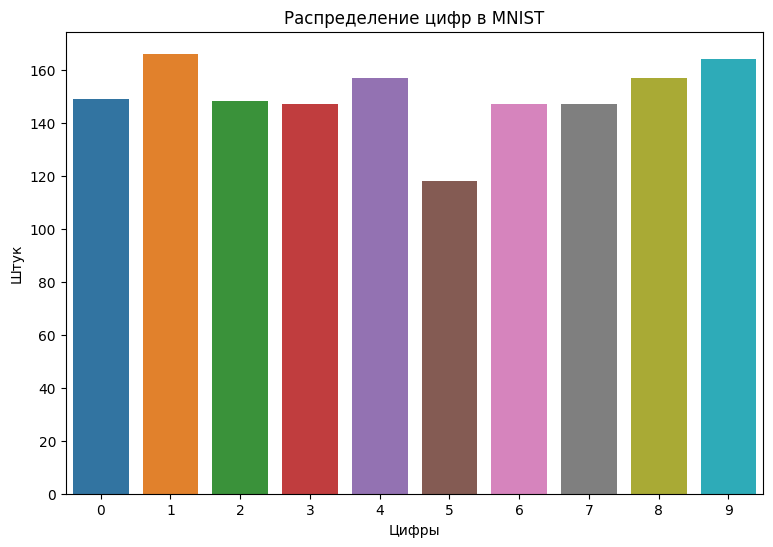

In [ ]:
# Выводим 16 картинок из датасета
for i in range(16):
    plt.subplot(4, 4, 1 + i)
    plt.axis("off")

    # отображение массива numpy как картинки;
    # cmap - карта цветов, используем серую 'gray'
    plt.imshow(x_viz[i], cmap="gray")
    plt.title(f"Метки: {y_viz[i]}")

    # Отступы по ширине и высоте между картинками
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.countplot(x=y_viz.numpy())
plt.xlabel("Цифры")
plt.ylabel("Штук")
plt.title("Распределение цифр в MNIST");

In [ ]:
# Функция изменения формы и масштабирования данных
def preprocess(x, y):
    # reshap - изменяет форму данных
    x = tf.reshape(x, shape=(-1, 784))
    # -1 - значит сохранить форму
    # 784 - 28 * 28 (Размер картинки)

    # Масштабируем данные
    x = x / 255
    return x, y


train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)
# map выполняет функцию preprocess для каждого элемента данных,
# к которым применяется

In [ ]:
# Функция инициализации Ксавье
def xavier_init(shape):
    # Вычисляем значения инициализации xavier для весовой матрицы
    in_dim, out_dim = shape

    # Задаем диапазон инициализации весов по схеме Ксавье
    xavier_lim = tf.sqrt(6.0) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))

    # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
    weight_vals = tf.random.uniform(
        shape=(in_dim, out_dim), minval=-xavier_lim, maxval=xavier_lim
    )
    return weight_vals

In [ ]:
# Класс полносвязанного слоя
class DenseLayer(tf.Module):
    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        # Инициализация размеров и функции активации
        self.out_dim = out_dim  # Определяем размерность выходов
        self.weight_init = weight_init  # Инициализируем веса
        self.activation = activation  # Задаем функцию активации
        self.built = False

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x):
        if not self.built:  # Если запущен первый раз проводим инициализацию
            # Вывод входного измерения на основе первого вызова
            self.in_dim = x.shape[1]

            # Инициализация весов
            self.w = tf.Variable(
                self.weight_init(shape=(self.in_dim, self.out_dim))
            )  # Объявление тензорных переменных

            # Инициализация смещения
            self.b = tf.Variable(
                tf.zeros(shape=(self.out_dim,))
            )  # Объявление тензорных переменных

            # Инициализация пройдена
            self.built = True

        # Вычисление прямого прохода
        y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона

        # Применение функции активации к уравнению персептрона
        return self.activation(y)

In [ ]:
# Многослойные перцептроны
class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x, preds=False):
        # Последовательное выполнение слоев модели
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Создание модели нейронной сети
mlp_model = MLP(
    [
        DenseLayer(out_dim=700, activation=tf.nn.relu),
        DenseLayer(out_dim=500, activation=tf.nn.relu),
        DenseLayer(out_dim=10),
    ]
)

In [ ]:
def cross_entropy_loss(y_pred, y):
    # Вычисление перекрестной энтропии с помощью разреженной операции
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)  # аналог np.mean для тензоров

In [ ]:
def accuracy(y_pred, y):
    # Вычисляем точность после извлечения предсказаний класса

    class_preds = tf.argmax(
        tf.nn.softmax(y_pred), axis=1
    )  # возвращает индекс максимального элемента

    # сравнение тензорных значений
    is_equal = tf.equal(y, class_preds)

    # аналог np.mean для тензоров
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [ ]:
# Алгоритмов оптимизации ADAM
class Adam:
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        # Инициализируем параметры оптимизатора и резервируем переменные
        self.beta_1 = beta_1  # гиперпараметр
        self.beta_2 = beta_2  # гиперпараметр
        self.learning_rate = learning_rate  # шаг обучения

        # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
        self.ep = ep

        self.t = 1.0
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        # Инициализируем переменные при первом вызове
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True

        # Обновите переменные модели с учетом их градиентов
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(
                self.beta_1 * self.v_dvar[i] + (1 - self.beta_1) * d_var
            )
            self.s_dvar[i].assign(
                self.beta_2 * self.s_dvar[i] + (1 - self.beta_2) * tf.square(d_var)
            )
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2**self.t))
            var.assign_sub(
                self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.ep))
            )
        self.t += 1.0
        return

In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    # Обновляем состояние модели с учетом пакета данных

    with tf.GradientTape() as tape:
        y_pred = model(x_batch)  # Предсказываем значение с текущими весами
        batch_loss = loss(y_pred, y_batch)  # Оцениваем ошибку на текущих весах

    batch_acc = acc(y_pred, y_batch)  # Оцениваем точность на текущих весах
    grads = tape.gradient(batch_loss, model.variables)  # Вычисляем градиенты

    # Обновляем переменные с учетом полученных градиентов
    optimizer.apply_gradients(grads, model.variables)

    # Возвращаем ошибку и точность на основе заданного пакета
    return (batch_loss, batch_acc)


def val_step(x_batch, y_batch, loss, acc, model):
    # Оцениваем модель на основе заданного пакета валидационных данных
    # без обучения на текущих весах
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc

In [ ]:
# Определяем функцию обучения
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    """Определение функции обучения

    Args:
        mlp: Модель обучения в нашем случае многослойный персепртон
        train_data: Train dataset
        val_data: Validate dataset
        loss: Функция потер
        acc: Функцию вычисления точности
        optimizer: Класс оптимизации
        epochs (int): Количество поколений

    Returns:
        train_losses (list): Массив потерь на тестовых данных
        train_accs (list): Массив точности на тестовых данных
        val_losses (list): Массив потерь на валидационных данных
        val_accs (list): Массив точности на валидационных данных
    """
    # Инициализация структур данных
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Отформатируем тренировочный цикл и начнем обучение
    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        # Выполняем итерацию по обучающим данным
        for x_batch, y_batch in train_data:
            # Вычисляем градиенты и обновляем параметры модели
            batch_loss, batch_acc = train_step(
                x_batch, y_batch, loss, acc, mlp, optimizer
            )
            # Следим за результатами обучения на пакетном уровне
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        # Повторяем процедуру проверки данных
        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        # Следим за производительностью модели на уровне эпохи
        train_loss, train_acc = (
            tf.reduce_mean(batch_losses_train),
            tf.reduce_mean(batch_accs_train),
        )
        val_loss, val_acc = (
            tf.reduce_mean(batch_losses_val),
            tf.reduce_mean(batch_accs_val),
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Эпоха: {epoch}")
        print(
            f"Обучающая ошибка: {train_loss:.3f}, Обучающая точность: {train_acc:.3f}"
        )
        print(
            f"Валидационная ошибка: {val_loss:.3f}, Валидационная точность: {val_acc:.3f}"
        )
    return train_losses, train_accs, val_losses, val_accs

In [ ]:
start_time = time.time()

train_losses, train_accs, val_losses, val_accs = train_model(
    mlp_model,
    train_data,
    val_data,
    loss=cross_entropy_loss,
    acc=accuracy,
    optimizer=Adam(),
    epochs=10,
)

training_time_1 = time.time() - start_time
print("--- %s seconds ---" % (training_time_1))

Эпоха: 0
Обучающая ошибка: 0.225, Обучающая точность: 0.935
Валидационная ошибка: 0.121, Валидационная точность: 0.965
Эпоха: 1
Обучающая ошибка: 0.080, Обучающая точность: 0.975
Валидационная ошибка: 0.094, Валидационная точность: 0.972
Эпоха: 2
Обучающая ошибка: 0.048, Обучающая точность: 0.985
Валидационная ошибка: 0.090, Валидационная точность: 0.974
Эпоха: 3
Обучающая ошибка: 0.033, Обучающая точность: 0.990
Валидационная ошибка: 0.103, Валидационная точность: 0.973
Эпоха: 4
Обучающая ошибка: 0.026, Обучающая точность: 0.992
Валидационная ошибка: 0.087, Валидационная точность: 0.978
Эпоха: 5
Обучающая ошибка: 0.021, Обучающая точность: 0.993
Валидационная ошибка: 0.110, Валидационная точность: 0.973
Эпоха: 6
Обучающая ошибка: 0.019, Обучающая точность: 0.993
Валидационная ошибка: 0.103, Валидационная точность: 0.976
Эпоха: 7
Обучающая ошибка: 0.020, Обучающая точность: 0.993
Валидационная ошибка: 0.100, Валидационная точность: 0.978
Эпоха: 8
Обучающая ошибка: 0.014, Обучающая точн

In [ ]:
def plot_metrics(train_losses, val_losses, metric_name):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, "b", label="Training")
    plt.plot(epochs, val_losses, "r", label="Validation")

    plt.title(metric_name)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

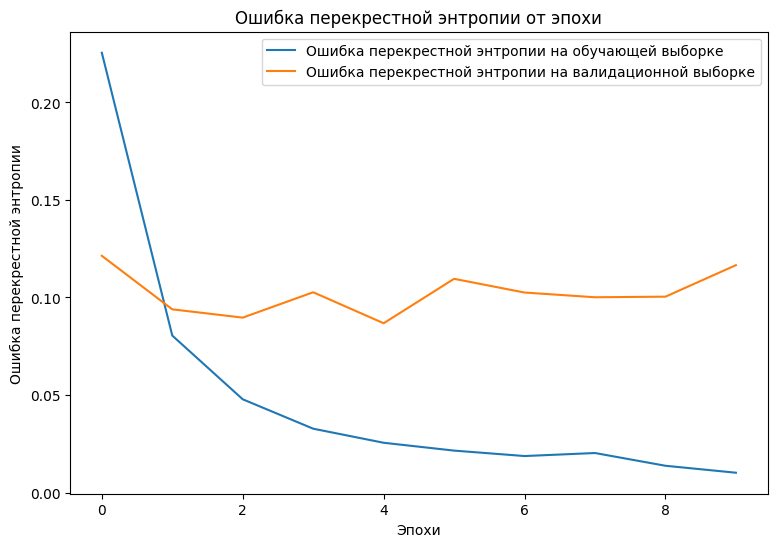

In [ ]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")

In [ ]:
plot_metrics(train_accs, val_accs, "точность")

In [ ]:
# Сохранение модели
class ExportModule(tf.Module):
    def __init__(self, model, preprocess, class_pred):
        # Инициализация функций предобработки и постобработки
        self.model = model
        self.preprocess = preprocess
        self.class_pred = class_pred

    @tf.function(
        input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]
    )
    def __call__(self, x):
        # Запускаем модуль экспорта для получения новых точек данных
        x = self.preprocess(x)
        y = self.model(x)
        y = self.class_pred(y)
        return y


def preprocess_test(x):
    # Модуль экспорта принимает необработанные и немаркированные данные
    x = tf.reshape(x, shape=[-1, 784])
    x = x / 255
    return x


def class_pred_test(y):
    # Сгенерируем прогнозы классов на основе выходных данных MLP
    return tf.argmax(tf.nn.softmax(y), axis=1)

In [ ]:
mlp_model_export = ExportModule(
    model=mlp_model, preprocess=preprocess_test, class_pred=class_pred_test
)

models = tempfile.mkdtemp()
save_path = os.path.join(models, "mlp_model_export")

tf.saved_model.save(mlp_model_export, save_path)
mlp_loaded = tf.saved_model.load(save_path)

In [ ]:
def accuracy_score(y_pred, y):
    # Общая функция точности
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [ ]:
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Точность на тестовой выборке: {test_acc:.3f}")

Точность на тестовой выборке: 0.977


In [ ]:
def accs_by_number(y_pred, y):
    print("Точность с разбивкой по цифрам :")
    print("---------------------------")
    label_accs = {}
    for label in range(10):
        label_ind = y == label

        # extract predictions for specific true label
        pred_label = y_pred[label_ind]
        labels = y[label_ind]

        # compute class-wise accuracy
        label_accs[label] = accuracy_score(pred_label, labels).numpy()
    
    return sorted(label_accs)

Точность с разбивкой по цифрам :
---------------------------
Цифра 2: 0.965
Цифра 0: 0.970
Цифра 4: 0.970
Цифра 9: 0.972
Цифра 5: 0.974
Цифра 7: 0.977
Цифра 6: 0.983
Цифра 8: 0.986
Цифра 3: 0.987
Цифра 1: 0.988


In [ ]:
label_access = accs_by_number(test_classes, y_test)

for key in label_access.keys():
    print(f"Цифра {key}: {label_access[key]:.3f}")

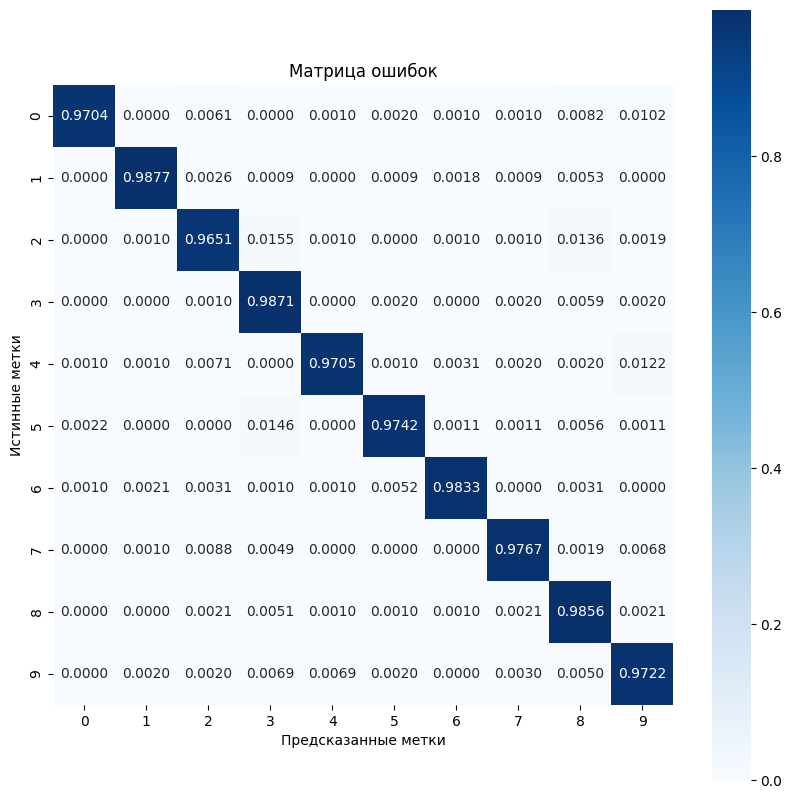

In [ ]:
import sklearn.metrics as sk_metrics
def show_confusion_matrix(test_labels, test_classes):
    # Вычисление матрицы ошибок и ее нормализация
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
    axis_labels = range(10)
    ax = sns.heatmap(
        confusion_normalized,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        cmap="Blues",
        annot=True,
        fmt=".4f",
        square=True,
    )
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")


show_confusion_matrix(y_test, test_classes)

---
1.2
---

In [ ]:
# Создание модели нейронной сети
mlp_model_2 = MLP(
    [
        DenseLayer(out_dim=750, activation=tf.nn.relu),
        DenseLayer(out_dim=500, activation=tf.nn.relu),
        DenseLayer(out_dim=250, activation=tf.nn.relu),
        DenseLayer(out_dim=10),
    ]
)

In [ ]:
start_time = time.time()
train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_model(
    mlp_model_2,
    train_data,
    val_data,
    loss=cross_entropy_loss,
    acc=accuracy,
    optimizer=Adam(),
    epochs=10,
)

training_time_2 = time.time() - start_time
print("--- %s seconds ---" % (training_time_2))

In [ ]:
mlp_model_export_2 = ExportModule(
    model=mlp_model_2, preprocess=preprocess_test, class_pred=class_pred_test
)

models = tempfile.mkdtemp()
save_path = os.path.join(models, "mlp_model_export")

tf.saved_model.save(mlp_model_export_2, save_path)
mlp_loaded_2 = tf.saved_model.load(save_path)

In [ ]:
test_classes_2 = mlp_loaded_2(x_test)
test_acc_2 = accuracy_score(test_classes_2, y_test)
print(f"Точность на тестовой выборке: {test_acc_2:.3f}")

In [ ]:
label_access_2 = accs_by_number(test_classes_2, y_test)

for key in label_access_2.keys():
    print(f"Цифра {key}: {label_access_2[key]:.3f}")

In [ ]:
show_confusion_matrix(y_test, test_classes_2)

Результат
---

In [ ]:
for key in range(10):
    print(f"Цифра {key} - было:{dict1[key]:.3f}, стало:{dict1[key]:.3f}")

In [ ]:
print(f"Время обучения модели:\n было:{training_time_1:.3f} секунд\n стало:{training_time_2:.3f} секунд")

---

# Задание 2

---

In [4]:
import os
import tempfile

import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Загрузка набора данных groove
_train_dataset, _val_dataset, _test_dataset = tfds.load(
    "groove/full-16000hz", split=["train", "validation", "test"]
)

Dl Completed...:   0%|          | 0/29 [00:00<?, ? file/s]

Dataset groove downloaded and prepared to /root/tensorflow_datasets/groove/full-16000hz/2.0.1. Subsequent calls will reuse this data.


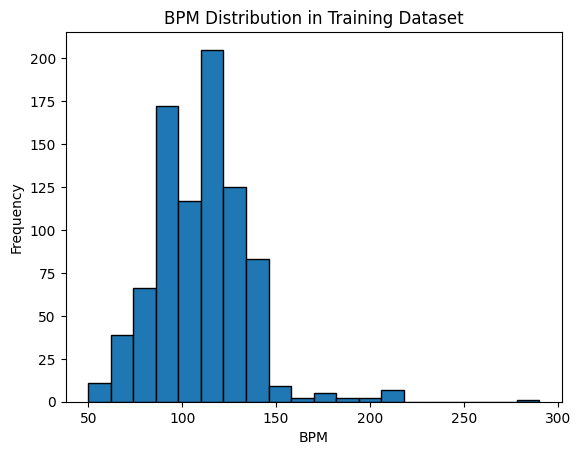

In [5]:
def extract_bpm(dataset):
    bpm_values = []
    for data in dataset:
        bpm = data["bpm"].numpy()
        bpm_values.append(bpm)
    return bpm_values


bpm_train = extract_bpm(_train_dataset)

plt.hist(bpm_train, bins=20, edgecolor="black")
plt.title("BPM Distribution in Training Dataset")
plt.xlabel("BPM")
plt.ylabel("Frequency")
plt.show()

In [53]:
from collections import Counter

cnt_bpm_dict = Counter(bpm_train)
print(cnt_bpm_dict)

Counter({120: 68, 95: 64, 100: 58, 140: 42, 125: 38, 92: 35, 93: 34, 105: 32, 110: 31, 112: 31, 116: 31, 128: 26, 130: 25, 122: 25, 144: 21, 78: 19, 70: 18, 114: 16, 84: 15, 75: 15, 115: 14, 118: 13, 67: 13, 90: 12, 83: 10, 60: 10, 96: 9, 148: 8, 98: 8, 135: 7, 215: 7, 94: 6, 145: 6, 63: 6, 104: 6, 102: 5, 86: 5, 80: 5, 108: 4, 124: 4, 142: 4, 88: 4, 101: 3, 132: 3, 127: 2, 180: 2, 89: 2, 134: 2, 170: 2, 200: 2, 126: 2, 82: 2, 185: 1, 64: 1, 50: 1, 99: 1, 87: 1, 176: 1, 152: 1, 72: 1, 136: 1, 162: 1, 290: 1, 117: 1, 182: 1, 158: 1})


In [6]:
def preprocess(data):
    # Преобразование аудио в спектрограмму
    audio = data["audio"]
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Добавление одного измерения
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    # Приведение спектрограмм к фиксированному размеру
    spectrogram = tf.image.resize(spectrogram, [128, 129])

    return spectrogram, data["bpm"]

In [7]:
train_dataset = (
    _train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
)
val_dataset = (
    _val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
)
test_dataset = (
    _test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
)

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(None, 129)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [28]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(128, 129, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [29]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [48]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
27/27 [==============================] - 11s 407ms/step - loss: 147.5756 - mae: 9.6041 - val_loss: 981.4283 - val_mae: 26.5483
Epoch 2/100
27/27 [==============================] - 9s 317ms/step - loss: 133.6661 - mae: 9.1482 - val_loss: 538.6220 - val_mae: 18.5500
Epoch 3/100
27/27 [==============================] - 8s 248ms/step - loss: 145.4099 - mae: 9.4627 - val_loss: 525.9537 - val_mae: 17.7904
Epoch 4/100
27/27 [==============================] - 10s 356ms/step - loss: 137.0762 - mae: 9.0688 - val_loss: 490.5637 - val_mae: 16.6462
Epoch 5/100
27/27 [==============================] - 10s 339ms/step - loss: 143.6280 - mae: 9.5209 - val_loss: 620.5291 - val_mae: 20.4007
Epoch 6/100
27/27 [==============================] - 8s 258ms/step - loss: 149.5823 - mae: 9.5438 - val_loss: 533.4031 - val_mae: 17.9069
Epoch 7/100
27/27 [==============================] - 8s 295ms/step - loss: 144.5173 - mae: 9.4197 - val_loss: 704.7560 - val_mae: 22.0690
Epoch 8/100
27/27 [============

In [66]:
print(history.history["loss"][-1])

54.00930404663086


In [ ]:
while history.history["loss"][-1] > 1:
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
27/27 [==============================] - 8s 277ms/step - loss: 59.2530 - mae: 5.9034 - val_loss: 1009.6219 - val_mae: 23.7990
Epoch 2/10
27/27 [==============================] - 7s 254ms/step - loss: 67.8278 - mae: 6.3018 - val_loss: 753.9171 - val_mae: 20.8668
Epoch 3/10
27/27 [==============================] - 8s 259ms/step - loss: 68.8957 - mae: 6.1205 - val_loss: 904.2274 - val_mae: 22.5364
Epoch 4/10
27/27 [==============================] - 9s 298ms/step - loss: 63.3458 - mae: 5.8131 - val_loss: 1691.9117 - val_mae: 35.5519
Epoch 5/10
27/27 [==============================] - 7s 234ms/step - loss: 66.9640 - mae: 6.2578 - val_loss: 2298.9243 - val_mae: 43.2816
Epoch 6/10
27/27 [==============================] - 9s 312ms/step - loss: 63.1231 - mae: 6.2522 - val_loss: 2450.9094 - val_mae: 45.0039
Epoch 7/10
27/27 [==============================] - 9s 319ms/step - loss: 70.9188 - mae: 6.4995 - val_loss: 1729.7574 - val_mae: 36.7441
Epoch 8/10
27/27 [=========================

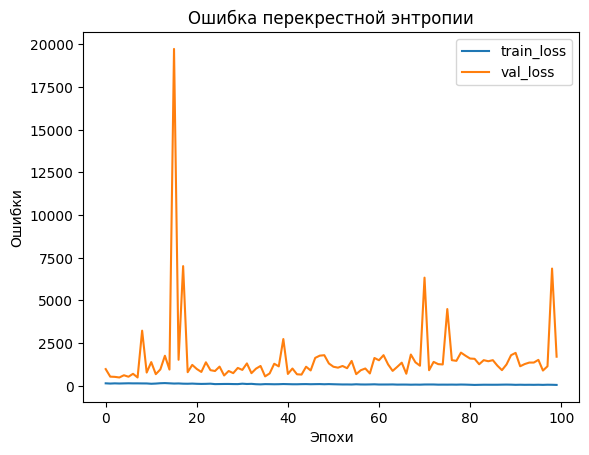

In [64]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Ошибка перекрестной энтропии")
plt.xlabel("Эпохи")
plt.ylabel("Ошибки")
plt.legend()
plt.show()

In [22]:
def get_bpm_predictions(dataset):
    y_true = []
    y_pred = []
    for spectrogram, bpm in dataset:
        preds = model.predict(spectrogram)
        y_true.extend(bpm.numpy())
        y_pred.extend(np.round(preds))  # Округление предсказанных значений
    return y_true, y_pred

In [40]:
y_true, y_pred = get_bpm_predictions(test_dataset)

1/1 [==============================] - 0s 27ms/step


In [41]:
print(y_pred)
print(y_true)

[array([111.], dtype=float32), array([103.], dtype=float32), array([110.], dtype=float32), array([86.], dtype=float32), array([104.], dtype=float32), array([121.], dtype=float32), array([81.], dtype=float32), array([95.], dtype=float32), array([102.], dtype=float32), array([118.], dtype=float32), array([75.], dtype=float32), array([113.], dtype=float32), array([111.], dtype=float32), array([99.], dtype=float32), array([104.], dtype=float32), array([106.], dtype=float32), array([83.], dtype=float32), array([116.], dtype=float32), array([106.], dtype=float32), array([92.], dtype=float32), array([128.], dtype=float32), array([106.], dtype=float32), array([97.], dtype=float32), array([119.], dtype=float32), array([90.], dtype=float32), array([90.], dtype=float32), array([98.], dtype=float32), array([106.], dtype=float32), array([116.], dtype=float32), array([108.], dtype=float32), array([105.], dtype=float32), array([87.], dtype=float32), array([106.], dtype=float32), array([90.], dtype=fl

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Округление предсказанных значений до ближайшего целого
y_pred_rounded = np.round(y_pred)

# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred_rounded)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

<ipython-input-15-b37c319c7cbc>:9: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


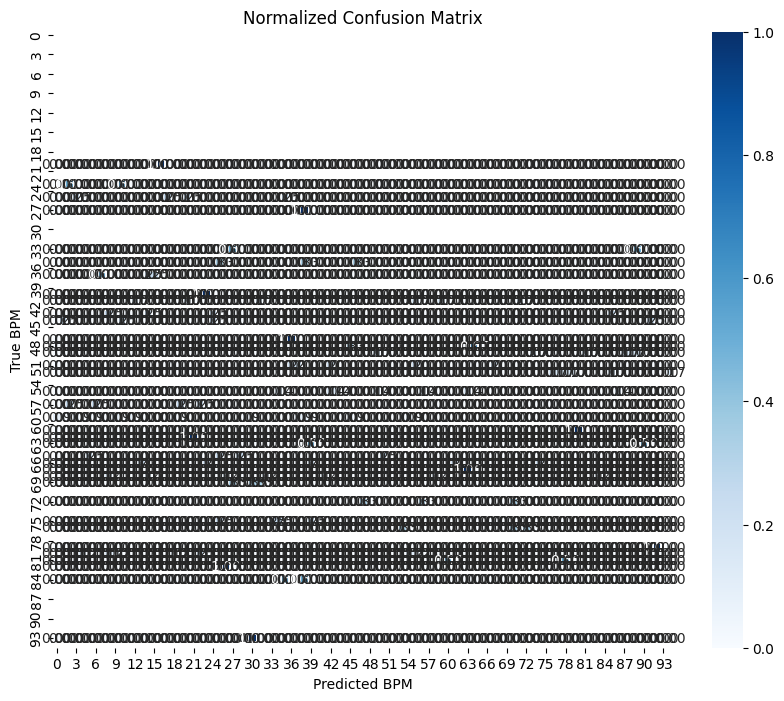

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted BPM")
plt.ylabel("True BPM")
plt.show()

In [16]:
def show_confusion_matrix(test_labels, test_classes):
    # Вычисление матрицы ошибок и ее нормализация
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
    axis_labels = range(10)
    ax = sns.heatmap(
        confusion_normalized,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        cmap="Blues",
        annot=True,
        fmt=".4f",
        square=True,
    )
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")


show_confusion_matrix(y_test, test_classes)

NameError: name 'y_test' is not defined

In [63]:
def accuracy_per_bpm(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    bpm_values = np.unique(y_true)
    accuracy_dict = {}

    for bpm in bpm_values:
        idx = np.where(y_true == bpm)
        true_bpm = np.array(y_true)[idx]
        pred_bpm = np.array(y_pred_rounded)[idx]
        accuracy = np.mean(abs(true_bpm - pred_bpm) < 5)
        # accuracy_dict[bpm] = accuracy
        count = len(true_bpm)
        accuracy_dict[bpm] = {"accuracy": accuracy, "count": count}

    return accuracy_dict


accuracy_dict = accuracy_per_bpm(y_true, y_pred)

for bpm, accuracy in accuracy_dict.items():
    print(
        f'BPM: {bpm}, Accuracy: {accuracy["accuracy"]:.2f}, Cnt: {accuracy["count"]}',
    )

BPM: 60, Accuracy: 0.00, Cnt: 1
BPM: 63, Accuracy: 0.00, Cnt: 2
BPM: 65, Accuracy: 0.00, Cnt: 4
BPM: 67, Accuracy: 0.00, Cnt: 1
BPM: 75, Accuracy: 0.00, Cnt: 2
BPM: 78, Accuracy: 0.00, Cnt: 3
BPM: 80, Accuracy: 0.00, Cnt: 4
BPM: 83, Accuracy: 1.00, Cnt: 1
BPM: 84, Accuracy: 0.33, Cnt: 6
BPM: 86, Accuracy: 0.00, Cnt: 4
BPM: 87, Accuracy: 0.75, Cnt: 4
BPM: 90, Accuracy: 0.00, Cnt: 1
BPM: 92, Accuracy: 0.00, Cnt: 3
BPM: 93, Accuracy: 0.00, Cnt: 6
BPM: 95, Accuracy: 0.60, Cnt: 5
BPM: 96, Accuracy: 0.17, Cnt: 6
BPM: 100, Accuracy: 0.43, Cnt: 7
BPM: 102, Accuracy: 0.00, Cnt: 4
BPM: 105, Accuracy: 0.18, Cnt: 11
BPM: 108, Accuracy: 1.00, Cnt: 1
BPM: 110, Accuracy: 0.00, Cnt: 1
BPM: 112, Accuracy: 0.50, Cnt: 2
BPM: 114, Accuracy: 0.00, Cnt: 4
BPM: 116, Accuracy: 0.40, Cnt: 5
BPM: 118, Accuracy: 0.00, Cnt: 1
BPM: 120, Accuracy: 0.14, Cnt: 7
BPM: 122, Accuracy: 0.33, Cnt: 3
BPM: 125, Accuracy: 0.00, Cnt: 3
BPM: 128, Accuracy: 0.00, Cnt: 4
BPM: 130, Accuracy: 0.67, Cnt: 3
BPM: 135, Accuracy: 0.00,